In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'car-object-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F843852%2F3866417%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240229%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240229T141445Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3a1f405068c5efb5338cbec1f9f89fe9193442d3e8d9c2865dbc956589dc9ff2a87d846058cea39e97f7036359fa57682807e20654aed36250ee520521a5910488aa54ceefa9884fd6428e0459a95ab4ae2a4dcf15ead8e6256a893f3806924dd66964f5ddaec15cba3cb38f02a3285ed65547111aa553a52fb5f7124955329b2fda5db66689503d3fc280f4bbe84445cc20aa32bf26d2f373ff7419fde4c486643e999aa28e8fe6618ce60824f07d9eaba36fe8901f0478c043575b8dcb14fa9fb8c0f40fc2bc729bb8bf13beb921d12f2e079b95ae9e276d54916ea6c022ce85b58ca8a017508c4abfe40379e40712db822009a2a96751d5717f623d43fe32'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117507383 bytes downloaded
Downloaded and uncompressed: car-object-detection
Data source import complete.


In [ ]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# Other
from pathlib import Path

In [ ]:
train_path = Path("../input/car-object-detection/data/training_images")
test_path = Path("../input/car-object-detection/data/testing_images")

In [ ]:
train = pd.read_csv("../input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

In [ ]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)

    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)

def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)


def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))

    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]

    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])


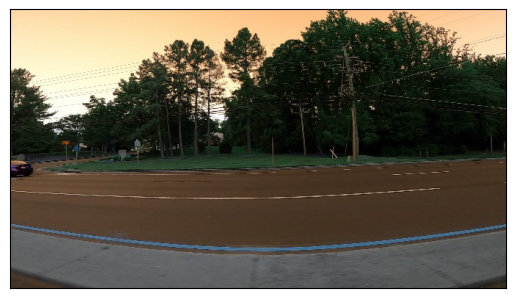

In [ ]:
display_image_from_file("vid_4_10520.jpg")

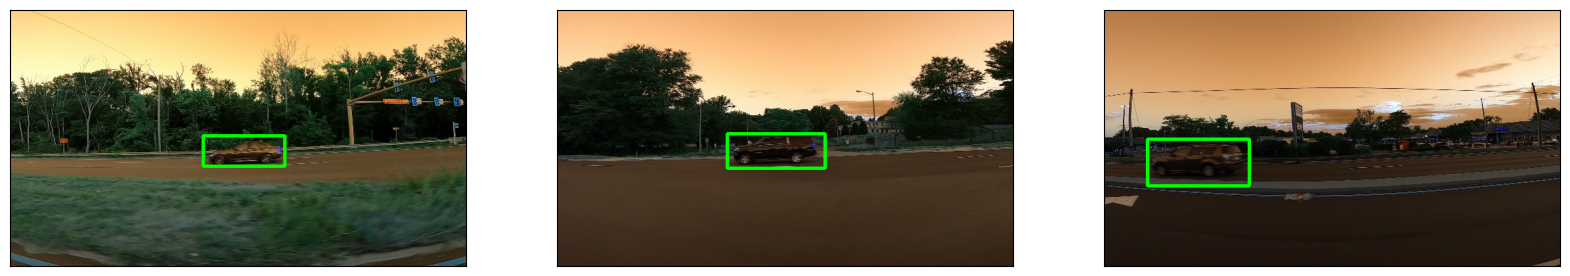

In [ ]:
display_grid()

In [ ]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))

        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

        yield {'image': images}, {'coords': bounding_box_coords}


The dictionary keys are crucial, as keras needs them to locate the correct input/output.

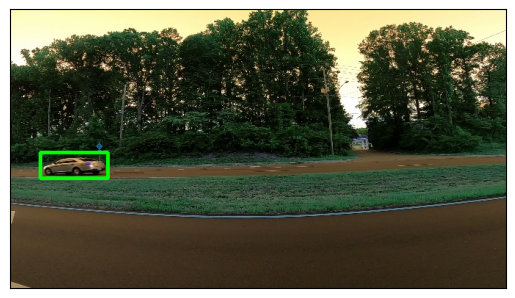

In [ ]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

In [ ]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 380, 676, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 380, 676, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 338, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 190, 338, 16)      64    

In [ ]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

In [ ]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)

    X = example['image']
    y = label['coords']

    pred_bbox = model.predict(X)[0]

    img = X[0]
    gt_coords = y[0]

    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)

    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

1/1 [==============================] - 0s 51ms/step


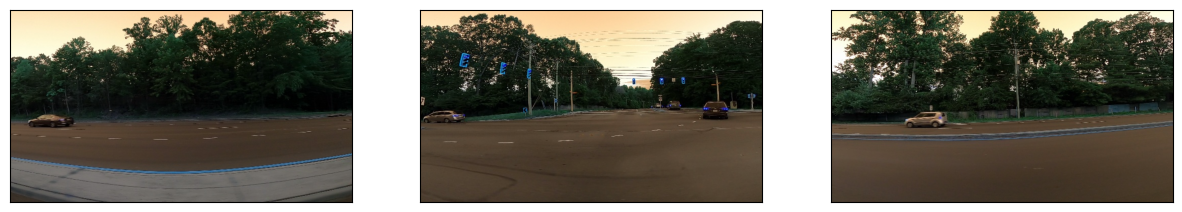

In [ ]:
test(model)

Epoch 1/9
  6/200 [..............................] - ETA: 43s - loss: 55347.6758 - accuracy: 0.5625

1/1 [==============================] - 0s 21ms/step


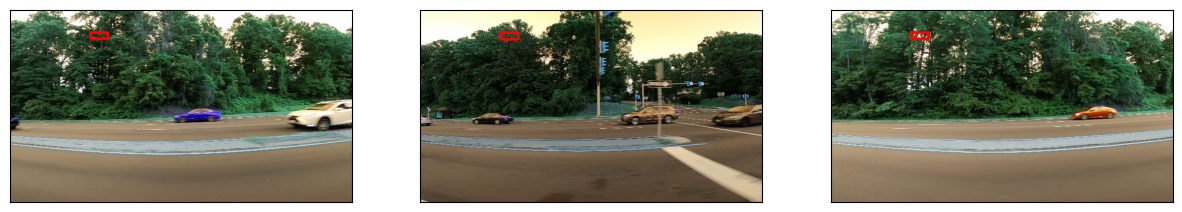

200/200 [==============================] - 73s 287ms/step - loss: 10127.6250 - accuracy: 0.7697
Epoch 2/9
1/1 [==============================] - 0s 29ms/step


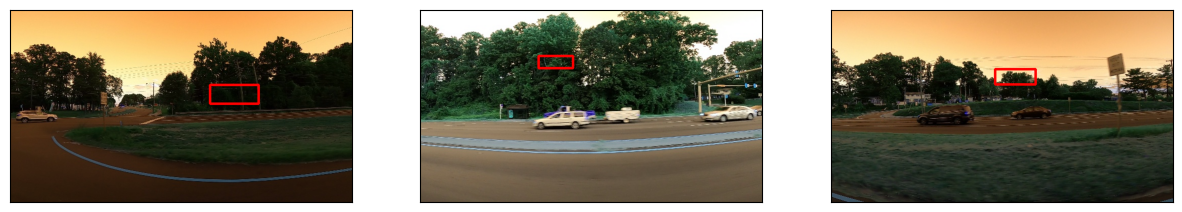

200/200 [==============================] - 57s 285ms/step - loss: 2224.0691 - accuracy: 0.9350
Epoch 3/9
1/1 [==============================] - 0s 42ms/step


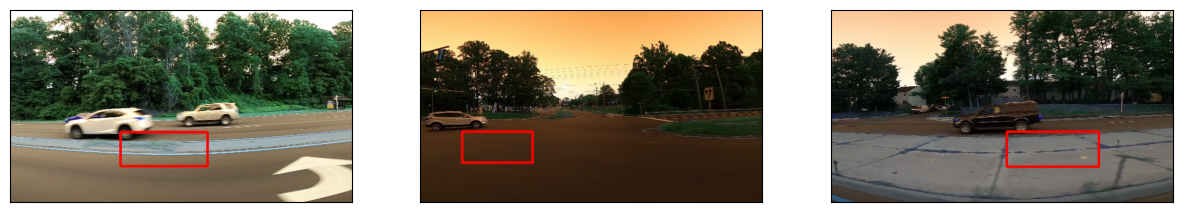

200/200 [==============================] - 57s 285ms/step - loss: 1366.3866 - accuracy: 0.9519
Epoch 4/9
1/1 [==============================] - 0s 39ms/step


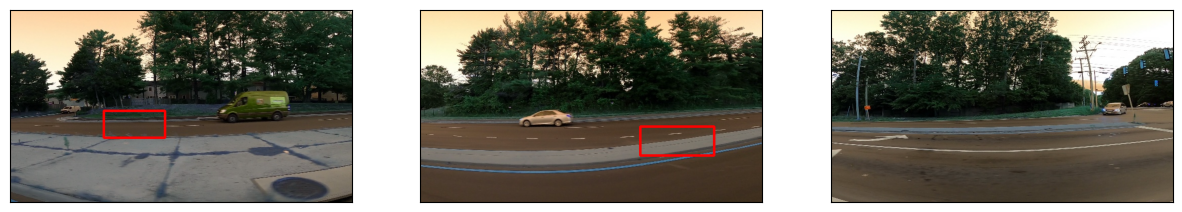

200/200 [==============================] - 57s 287ms/step - loss: 1022.5494 - accuracy: 0.9556
Epoch 5/9
1/1 [==============================] - 0s 54ms/step


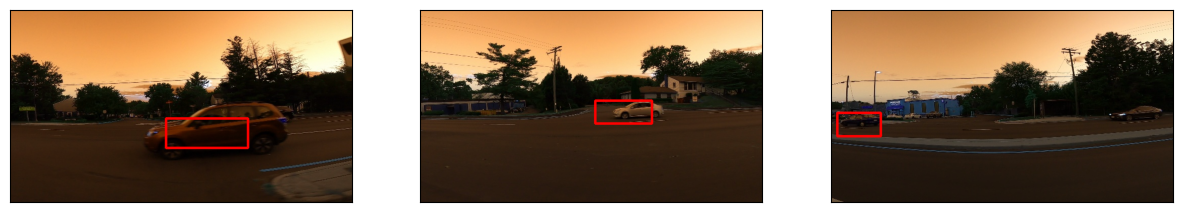

200/200 [==============================] - 58s 290ms/step - loss: 1133.3810 - accuracy: 0.9641
Epoch 6/9
1/1 [==============================] - 0s 27ms/step


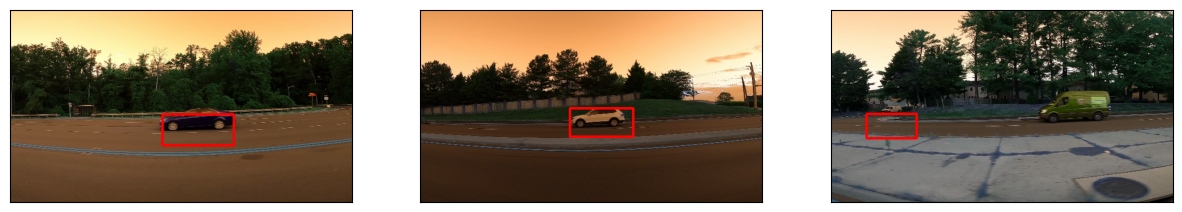

200/200 [==============================] - 57s 287ms/step - loss: 647.7576 - accuracy: 0.9725
Epoch 7/9
1/1 [==============================] - 0s 27ms/step


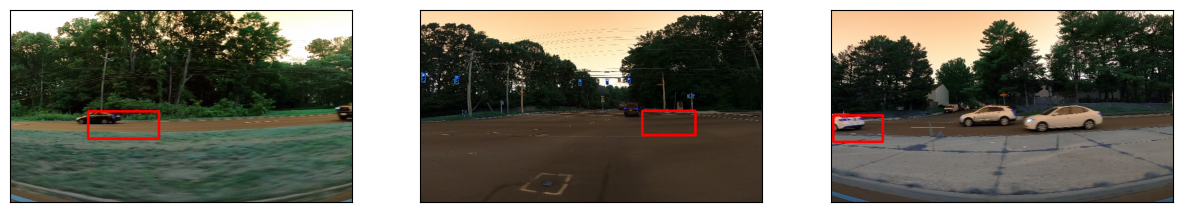

200/200 [==============================] - 59s 293ms/step - loss: 442.3303 - accuracy: 0.9781
Epoch 8/9
1/1 [==============================] - 0s 40ms/step


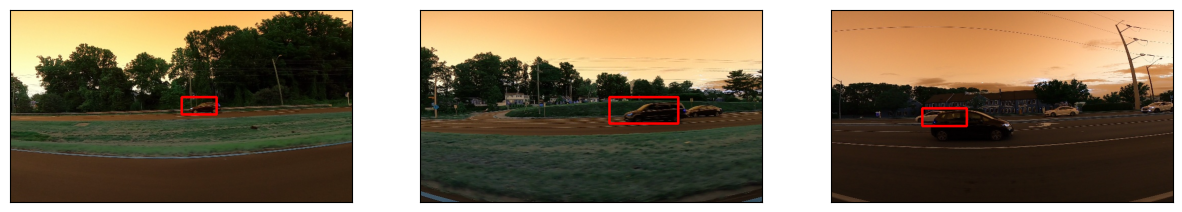

200/200 [==============================] - 58s 289ms/step - loss: 330.0675 - accuracy: 0.9809
Epoch 9/9
1/1 [==============================] - 0s 29ms/step


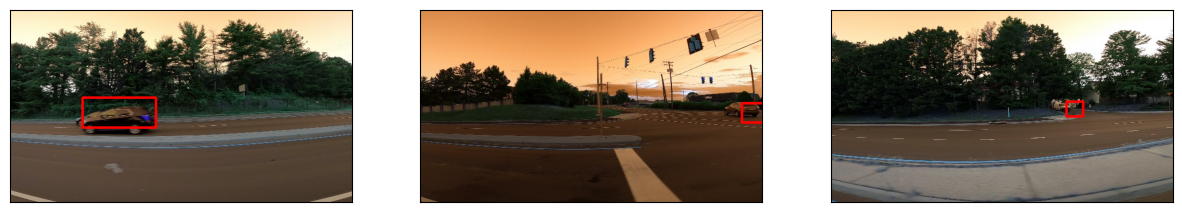

200/200 [==============================] - 59s 295ms/step - loss: 241.1128 - accuracy: 0.9803


In [ ]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=200,
        callbacks=[
            ShowTestImages(),
        ]
    )

In [ ]:
model.save('car-object-detection.h5')